# Comentarios

https://www.machinelearningplus.com/nlp/topic-modeling-gensim-python/#17howtofindtheoptimalnumberoftopicsforlda

https://towardsdatascience.com/topic-modeling-singapores-subreddit-comments-with-natural-language-processing-336d15da3ff4

In [2]:
import pandas as pd
import gensim
import matplotlib.pyplot as plt
from gensim.utils import simple_preprocess
import spacy
from spacy.lang.en import English
from gensim import corpora
import os
import pickle
from gensim.models import CoherenceModel
from gensim.models.wrappers import LdaMallet

In [5]:
com_gb = pd.read_csv('com_gb.csv', sep=';', encoding='latin1')
com_gb = com_gb.drop(com_gb[com_gb['Cuerpo'] == "[deleted]"].index)
com_gb = com_gb.drop(com_gb[com_gb['Cuerpo'] == "[removed]"].index)
com_gb.to_csv('com_gb2.csv', sep=';') 

In [7]:
df_gb = pd.read_csv('com_gb2.csv', sep=';', encoding='latin1').drop(['Unnamed: 0', 'Unnamed: 0.1', 'Score', 'Autor', 'ParentID', 'Autor', 'Creacion', 'Submission', 'ID'], axis=1)
df_gb

,Cuerpo
0,Well that just made my day
1,This is the best one I've seen. Bravo
2,I saw Bethesda... I thought could it be... Was...
3,"Dammit, Todd!"
4,Joking aside I once bought FInal Fantasy IV Ad...
...,...
63323,Q5 is the screen name
63324,The screen is called Q5 since it's from the Bl...
63325,I bought a screen and precut shell combo off A...
63326,I got the shell and screen from a US based sel...


In [8]:
def preprocess(comment):
    
    # Tokenize
    def sent_to_words(sentences):
        for sentence in sentences:
            yield(gensim.utils.simple_preprocess(str(sentence), 
                  deacc=True))
    
    data_words = list(sent_to_words(comment)) 
    
    # Remove Stop words & Short Words
    from nltk.corpus import stopwords
    stop_words = stopwords.words('english')
    stop_words.extend(['congrats', 'lol', 'yup', 'thanks', 'nope', 
                       'http', 'www', 'com', 'https','amp', 'sg', 
                       'reddit', 'gt', 'f', 'dope', 'xd'])
    
    def remove_stopwords(texts):
        return [[word for word in simple_preprocess(str(doc)) if 
                 word not in stop_words and len(word) > 2] for doc 
                 in texts]
    
    data_words_nostops = remove_stopwords(data_words)
    
    # Bigrams
    bigram_config = gensim.models.Phrases(data_words_nostops,
                                          min_count=5,
                                          threshold=100) 
    bigram_mod = gensim.models.phrases.Phraser(bigram_config)
 
    def make_bigrams(texts):
        return [bigram_mod[doc] for doc in texts]
    
    bigrams_list = make_bigrams(data_words_nostops)
    
    # Lemmatization
    def lemmatization(texts):
    
        nlp = spacy.load('en', disable=['parser', 'ner'])
        allowed_postags = ['NOUN', 'ADJ']
        texts_out = []
    
        for sent in texts:
            doc = nlp(" ".join(sent)) 
            texts_out.append([token.lemma_ for token in doc if
                              token.pos_ in allowed_postags])
            
        return texts_out
    
    data_lemmatized = lemmatization(bigrams_list)
    
    # Create Dictionary
    id2word = corpora.Dictionary(data_lemmatized)
    # Create Corpus
    corpus = [id2word.doc2bow(text) for text in data_lemmatized]
    
    #return corpus, id2word, data_lemmatized
    return data_lemmatized

In [9]:
os.environ.update({'MALLET_HOME':r'C:/Users/javie/mallet-2.0.8'})
mallet_path = r'C:/Users/javie/mallet-2.0.8/bin/mallet.bat'

def compute_coherence_values(dictionary, corpus, texts, limit, start=2, step=3):
    """
    Compute c_v coherence for various number of topics

    Parameters:
    ----------
    dictionary : Gensim dictionary
    corpus : Gensim corpus
    texts : List of input texts
    limit : Max num of topics

    Returns:
    -------
    model_list : List of LDA topic models
    coherence_values : Coherence values corresponding to the LDA model with respective number of topics
    """
    coherence_values = []
    model_list = []
    for num_topics in range(start, limit, step):
        model = gensim.models.wrappers.LdaMallet(mallet_path, corpus=corpus, num_topics=num_topics, id2word=dictionary, random_seed=10)
        model_list.append(model)
        coherencemodel = CoherenceModel(model=model, texts=texts, dictionary=dictionary, coherence='c_v')
        coherence_values.append(coherencemodel.get_coherence())

    return model_list, coherence_values

In [11]:
gb = preprocess(df_gb['Cuerpo'])

In [12]:
dictionary = corpora.Dictionary(gb)
corpus = [dictionary.doc2bow(text) for text in gb]
pickle.dump(corpus, open('corpus.pkl', 'wb'))

In [13]:
model_list, coherence_values = compute_coherence_values(dictionary=dictionary, corpus=corpus, texts=gb, start=2, limit=20, step=6)

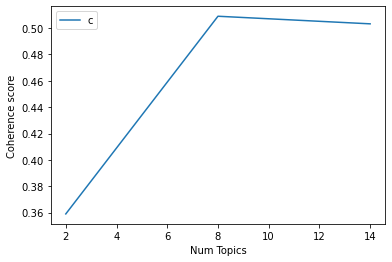

In [18]:
limit=20; start=2; step=6;
x = range(start, limit, step)
plt.plot(x, coherence_values)
plt.xlabel("Num Topics")
plt.ylabel("Coherence score")
plt.legend(("coherence_values"), loc='best')
plt.show()

In [19]:
for m, cv in zip(x, coherence_values):
    print("Num Topics =", m, " has Coherence Value of", round(cv, 4))

Num Topics = 2  has Coherence Value of 0.359
Num Topics = 8  has Coherence Value of 0.5089
Num Topics = 14  has Coherence Value of 0.5031


In [20]:
optimal_model = model_list[1]
model_topics = optimal_model.show_topics(formatted=False)
a10 = optimal_model.print_topics(num_words=10)
a10

[(0,
  '0.106*"good" + 0.037*"pokemon" + 0.026*"cart" + 0.026*"version" + 0.019*"red" + 0.019*"day" + 0.018*"friend" + 0.017*"cheap" + 0.017*"worth" + 0.017*"blue"'),
 (1,
  '0.240*"game" + 0.038*"year" + 0.033*"lot" + 0.030*"price" + 0.022*"stuff" + 0.019*"system" + 0.018*"console" + 0.017*"store" + 0.016*"money" + 0.015*"fun"'),
 (2,
  '0.083*"nice" + 0.078*"great" + 0.061*"love" + 0.060*"button" + 0.046*"awesome" + 0.039*"amazing" + 0.037*"collection" + 0.028*"beautiful" + 0.024*"job" + 0.024*"black"'),
 (3,
  '0.061*"battery" + 0.027*"part" + 0.025*"bit" + 0.019*"switch" + 0.018*"small" + 0.017*"big" + 0.017*"hand" + 0.016*"life" + 0.016*"long" + 0.016*"power"'),
 (4,
  '0.039*"case" + 0.035*"thing" + 0.033*"bad" + 0.032*"work" + 0.028*"good" + 0.023*"box" + 0.022*"cartridge" + 0.019*"picture" + 0.018*"clean" + 0.016*"plastic"'),
 (5,
  '0.121*"screen" + 0.064*"color" + 0.061*"gameboy" + 0.054*"original" + 0.053*"shell" + 0.048*"boy" + 0.036*"gbc" + 0.025*"light" + 0.023*"pocket" +

In [21]:
def format_topics_sentences(ldamodel, corpus, texts):
    # Init output
    sent_topics_df = pd.DataFrame()

    # Get main topic in each document
    for i, row in enumerate(ldamodel[corpus]):
        row = sorted(row, key=lambda x: (x[1]), reverse=True)
        # Get the Dominant topic, Perc Contribution and Keywords for each document
        for j, (topic_num, prop_topic) in enumerate(row):
            if j == 0:  # => dominant topic
                wp = ldamodel.show_topic(topic_num)
                topic_keywords = ", ".join([word for word, prop in wp])
                sent_topics_df = sent_topics_df.append(pd.Series([int(topic_num), round(prop_topic,4), topic_keywords]), ignore_index=True)
            else:
                break
    sent_topics_df.columns = ['Dominant_Topic', 'Perc_Contribution', 'Topic_Keywords']

    # Add original text to the end of the output
    sent_topics_df = pd.concat([sent_topics_df, texts], axis=1)
    return(sent_topics_df)

In [22]:
df_topic_sents_keywords = format_topics_sentences(ldamodel=optimal_model, corpus=corpus, texts=df_gb)
df_topic_sents_keywords

,Dominant_Topic,Perc_Contribution,Topic_Keywords,Cuerpo
0,0.0,0.1378,"good, pokemon, cart, version, red, day, friend...",Well that just made my day
1,7.0,0.1373,"time, cool, video, man, kid, day, play, custom...",This is the best one I've seen. Bravo
2,2.0,0.1400,"nice, great, love, button, awesome, amazing, c...",I saw Bethesda... I thought could it be... Was...
3,0.0,0.1250,"good, pokemon, cart, version, red, day, friend...","Dammit, Todd!"
4,5.0,0.1500,"screen, color, gameboy, original, shell, boy, ...",Joking aside I once bought FInal Fantasy IV Ad...
...,...,...,...,...
63323,5.0,0.1422,"screen, color, gameboy, original, shell, boy, ...",Q5 is the screen name
63324,5.0,0.1422,"screen, color, gameboy, original, shell, boy, ...",The screen is called Q5 since it's from the Bl...
63325,5.0,0.1844,"screen, color, gameboy, original, shell, boy, ...",I bought a screen and precut shell combo off A...
63326,0.0,0.1422,"good, pokemon, cart, version, red, day, friend...",I got the shell and screen from a US based sel...


In [23]:
sent_topics_sorteddf_mallet = pd.DataFrame()
sent_topics_outdf_grpd = df_topic_sents_keywords.groupby('Dominant_Topic')
for i, grp in sent_topics_outdf_grpd:
    sent_topics_sorteddf_mallet = pd.concat([sent_topics_sorteddf_mallet, 
                                             grp.sort_values(['Perc_Contribution'], ascending=[0]).head(1)], 
                                            axis=0)
    sent_topics_sorteddf_mallet.reset_index(drop=True, inplace=True)

# Format
sent_topics_sorteddf_mallet.columns = ['Topic_Num', "Topic_Perc_Contrib", "Keywords", "Text"]

# Show
sent_topics_sorteddf_mallet

,Topic_Num,Topic_Perc_Contrib,Keywords,Text
0,0.0,0.4073,"good, pokemon, cart, version, red, day, friend...",I cannot believe it's been this long! Japanese...
1,1.0,0.4895,"game, year, lot, price, stuff, system, console...",I'd love to! \n\nI'm not sure how many of thes...
2,2.0,0.2682,"nice, great, love, button, awesome, amazing, c...",This is amazing! I actually like the white but...
3,3.0,0.3723,"battery, part, bit, switch, small, big, hand, ...",It certainly may be - I've honestly only been ...
4,4.0,0.4382,"case, thing, bad, work, good, box, cartridge, ...","Alright, but it's definitely not the most gent..."
5,5.0,0.6720,"screen, color, gameboy, original, shell, boy, ...",*A relevant comment in this thread was deleted...
6,6.0,0.7295,"people, thing, post, issue, real, reason, hard...",Retrosix just made another post claiming that ...
7,7.0,0.5361,"time, cool, video, man, kid, day, play, custom...","**thewildjr**, your reminder arrives in **1 ye..."


In [24]:
sent_topics_sorteddf_mallet.to_csv('Pruebasota.csv', sep=';')

In [25]:
df_topic_sents_keywords

,Dominant_Topic,Perc_Contribution,Topic_Keywords,Cuerpo
0,0.0,0.1378,"good, pokemon, cart, version, red, day, friend...",Well that just made my day
1,7.0,0.1373,"time, cool, video, man, kid, day, play, custom...",This is the best one I've seen. Bravo
2,2.0,0.1400,"nice, great, love, button, awesome, amazing, c...",I saw Bethesda... I thought could it be... Was...
3,0.0,0.1250,"good, pokemon, cart, version, red, day, friend...","Dammit, Todd!"
4,5.0,0.1500,"screen, color, gameboy, original, shell, boy, ...",Joking aside I once bought FInal Fantasy IV Ad...
...,...,...,...,...
63323,5.0,0.1422,"screen, color, gameboy, original, shell, boy, ...",Q5 is the screen name
63324,5.0,0.1422,"screen, color, gameboy, original, shell, boy, ...",The screen is called Q5 since it's from the Bl...
63325,5.0,0.1844,"screen, color, gameboy, original, shell, boy, ...",I bought a screen and precut shell combo off A...
63326,0.0,0.1422,"good, pokemon, cart, version, red, day, friend...",I got the shell and screen from a US based sel...


In [26]:
# Number of Documents for Each Topic
topic_counts = df_topic_sents_keywords['Dominant_Topic'].value_counts()

# Percentage of Documents for Each Topic
topic_contribution = round(topic_counts/topic_counts.sum(), 4)

# Topic Number and Keywords
topic_num_keywords = sent_topics_sorteddf_mallet[['Topic_Num', 'Keywords']]

# Concatenate Column wise
df_dominant_topics = pd.concat([topic_num_keywords, topic_counts, topic_contribution], axis=1)

# Change Column names
df_dominant_topics.columns = ['Dominant_Topic', 'Topic_Keywords', 'Num_Documents', 'Perc_Documents']

# Show
df_dominant_topics

,Dominant_Topic,Topic_Keywords,Num_Documents,Perc_Documents
0.0,0.0,"good, pokemon, cart, version, red, day, friend...",20489,0.3235
1.0,1.0,"game, year, lot, price, stuff, system, console...",6988,0.1103
2.0,2.0,"nice, great, love, button, awesome, amazing, c...",9656,0.1525
3.0,3.0,"battery, part, bit, switch, small, big, hand, ...",5618,0.0887
4.0,4.0,"case, thing, bad, work, good, box, cartridge, ...",5410,0.0854
5.0,5.0,"screen, color, gameboy, original, shell, boy, ...",5508,0.0870
6.0,6.0,"people, thing, post, issue, real, reason, hard...",4380,0.0692
7.0,7.0,"time, cool, video, man, kid, day, play, custom...",5279,0.0834
